<a href="https://colab.research.google.com/github/paritachavda/Computer-Vision/blob/master/img_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-3.4.7.28:
  Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 77kB/s 
     |████████████████████████████████| 20.0MB 82kB/s 
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: gym 0.15.4 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
  Found 

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!unzip -q '/content/drive/My Drive/Datasets/LunchRoom.zip'

replace LunchRoom/Calibration.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

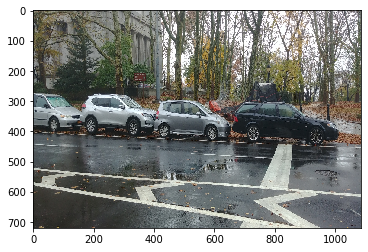

(<matplotlib.image.AxesImage at 0x7fd12a084a58>, None)

In [3]:
img1 = cv2.imread('/content/drive/My Drive/computer vision/1.png')
img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1rgb), plt.show()

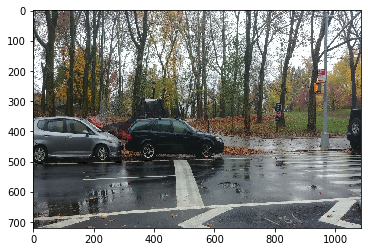

(<matplotlib.image.AxesImage at 0x7fd129be38d0>, None)

In [4]:
img2 = cv2.imread('/content/drive/My Drive/computer vision/2.png')
img2rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2rgb), plt.show()

In [0]:
surf = cv2.xfeatures2d_SURF().create(2000)    # threshold of Hessian matrix
# find keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)

# FLANN-kNN parameters
flann_index = 1    # KD-tree index
index_params = dict(algorithm=flann_index, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

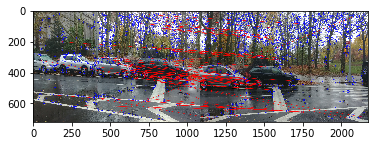

(<matplotlib.image.AxesImage at 0x7fd128076278>, None)

In [6]:
matcheslist = [[0, 0] for i in range(len(matches))]
good, pts1, pts2 = [], [], []
# search
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        matcheslist[i] = [1, 0]
# draw
draw_params = dict(matchColor=(0, 0, 255),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matcheslist,
                   flags=0)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2,
                         matches, None, **draw_params)
img3rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img3rgb), plt.show()

In [0]:
min_matches = 10

if len(good) < min_matches:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None
else:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # apply perspective transform to img2
    warpImg = cv2.warpPerspective(img2, np.array(M), (img2.shape[1]*2, img2.shape[0]),
                                  flags=cv2.WARP_INVERSE_MAP)
    # padding img1 with 0
    img1 = cv2.copyMakeBorder(img1, 0, 0, 0, img2.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))

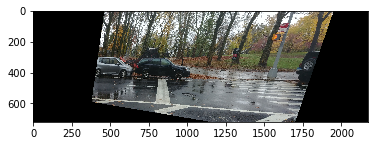

(<matplotlib.image.AxesImage at 0x7fd1280552e8>, None)

In [8]:
warpImgrgb = cv2.cvtColor(warpImg, cv2.COLOR_BGR2RGB)
plt.imshow(warpImgrgb), plt.show()

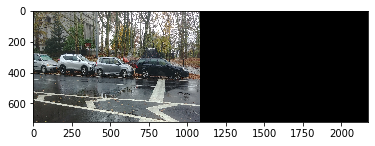

(<matplotlib.image.AxesImage at 0x7fd127fab940>, None)

In [9]:
img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1rgb), plt.show()

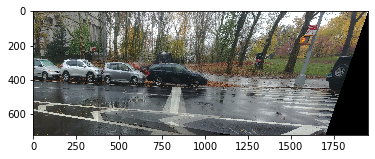

(<matplotlib.image.AxesImage at 0x7fd127f1c630>, None)

In [10]:
    rows, cols = warpImg.shape[:2]
    # find boundary of warpImg
    for col in range(0, cols):
        if warpImg[:, col].any():
            left = col
            break
    for col in range(cols-1, 0, -1):
        if warpImg[:, col].any():
            right = col
            break
    # stitch
    output = np.zeros([rows, right, 3], np.uint8)
    for col in range(0, right):
        if not img1[:, col].any():
            output[:, col] = warpImg[:, col]
        elif not warpImg[:, col].any():
            output[:, col] = img1[:, col]
        else:
            img1_len = float(col)
            warpImg_len = float(abs(col - right))
            alpha = img1_len / (img1_len + warpImg_len)
            output[:, col] = np.clip(img1[:, col] * (1-alpha) + warpImg[:, col] * alpha, 0, 255)
    # draw
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(output), plt.show()

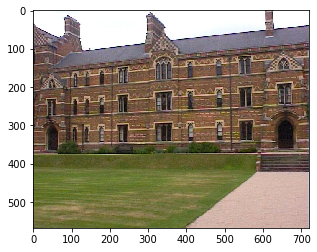

(<matplotlib.image.AxesImage at 0x7fd127efd2b0>, None)

In [11]:
img1 = cv2.imread('/content/drive/My Drive/computer vision/project/keble_a.jpg')
img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1rgb), plt.show()

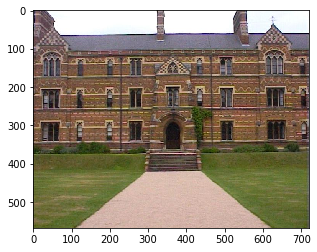

(<matplotlib.image.AxesImage at 0x7fd127ed7e48>, None)

In [12]:
img2 = cv2.imread('/content/drive/My Drive/computer vision/project/keble_b.jpg')
img2rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2rgb), plt.show()

In [0]:
surf = cv2.xfeatures2d_SURF().create(2000)    # threshold of Hessian matrix
# find keypoints and descriptors with SURF
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)

# FLANN-kNN parameters
flann_index = 1    # KD-tree index
index_params = dict(algorithm=flann_index, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

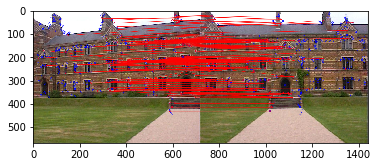

(<matplotlib.image.AxesImage at 0x7fd1280b6080>, None)

In [14]:
matcheslist = [[0, 0] for i in range(len(matches))]
good, pts1, pts2 = [], [], []
# search
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        matcheslist[i] = [1, 0]
# draw
draw_params = dict(matchColor=(0, 0, 255),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matcheslist,
                   flags=0)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2,
                         matches, None, **draw_params)
img3rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img3rgb), plt.show()

In [0]:
min_matches = 10

if len(good) < min_matches:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None
else:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    # apply perspective transform to img2
    warpImg = cv2.warpPerspective(img2, np.array(M), (img2.shape[1]*2, img2.shape[0]),
                                  flags=cv2.WARP_INVERSE_MAP)
    # padding img1 with 0
    img1 = cv2.copyMakeBorder(img1, 0, 0, 0, img2.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))

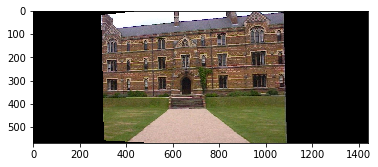

(<matplotlib.image.AxesImage at 0x7fd127d727f0>, None)

In [18]:
warpImgrgb = cv2.cvtColor(warpImg, cv2.COLOR_BGR2RGB)
plt.imshow(warpImgrgb), plt.show()

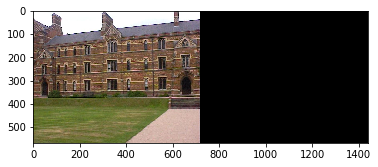

(<matplotlib.image.AxesImage at 0x7fd127d593c8>, None)

In [19]:
img1rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1rgb), plt.show()

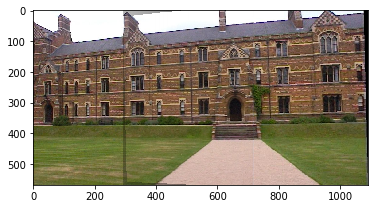

(<matplotlib.image.AxesImage at 0x7fd127cc45c0>, None)

In [20]:
    rows, cols = warpImg.shape[:2]
    # find boundary of warpImg
    for col in range(0, cols):
        if warpImg[:, col].any():
            left = col
            break
    for col in range(cols-1, 0, -1):
        if warpImg[:, col].any():
            right = col
            break
    # stitch
    output = np.zeros([rows, right, 3], np.uint8)
    for col in range(0, right):
        if not img1[:, col].any():
            output[:, col] = warpImg[:, col]
        elif not warpImg[:, col].any():
            output[:, col] = img1[:, col]
        else:
            img1_len = float(col)
            warpImg_len = float(abs(col - right))
            alpha = img1_len / (img1_len + warpImg_len)
            output[:, col] = np.clip(img1[:, col] * (1-alpha) + warpImg[:, col] * alpha, 0, 255)
    # draw
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(output), plt.show()